In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool
import catboost as cb
from scrapping import df_new
from scrapping import intrinsic_value_next
from pandas.api.types import is_object_dtype
from pandas.api.types import is_datetime64_dtype
import catboost as cb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
from keras.models import Sequential
from keras.layers import Dense, LSTM
import plotly.graph_objects as go
import plotly.express as px
from statistics import median
import copy
import yfinance as yf
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [7]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [8]:
entered_ticket='INTC'
df=df_new(entered_ticket)

In [9]:
output=intrinsic_value_next(df)

1/1 [==============================] - 0s 328ms/step


In [10]:
print(output)

[31.75705337524414, 0.027098651975393295]


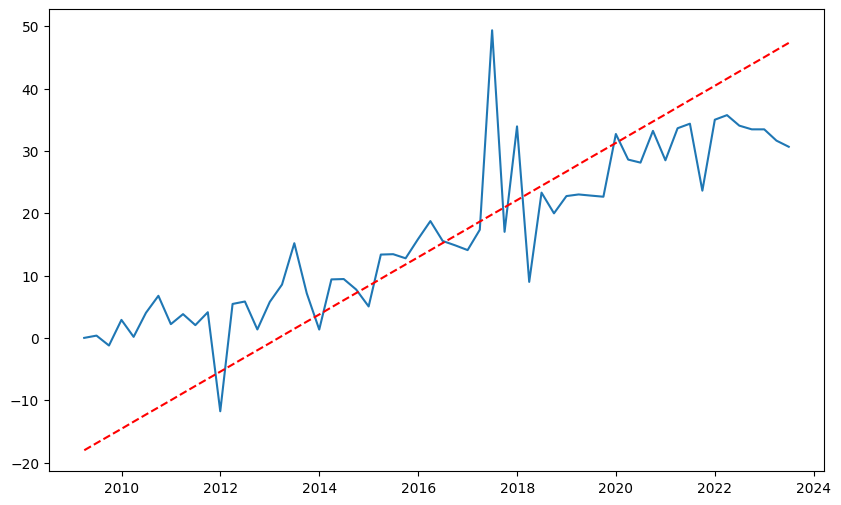

In [20]:
z = np.polyfit(df['Intrinsic Value'], df.index, 1)
p = np.poly1d(z)
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Intrinsic Value'])
plt.plot(df['Date'], p(df.index),  "r--")
plt.show()

In [21]:
df_test=df.copy()

In [22]:
data=df_test['FCF'][::-1]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

train_data=scaled_data
# train_data = scaled_data[:int(0.7 * len(data))]
# test_data = scaled_data[int(0.7 * len(data)):]

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X_train, y_train = create_sequences(train_data, seq_length)
# X_test, y_test = create_sequences(test_data, seq_length)

X_test = scaled_data[-4-seq_length:-4]
X_test = X_test.reshape(1, seq_length, -1)

model = Sequential([
    LSTM(4, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(4),
    Dense(1)
])

# model.summary()

model.compile(optimizer='adam', loss='mse')
history=model.fit(X_train, y_train, epochs=350, verbose=False)

In [23]:
# y_pred=model.predict(X_test)

In [24]:
# from sklearn.metrics import mean_squared_error
# mse_test=mean_squared_error(y_test, y_pred)
# data=pd.DataFrame({
#     'y_test': np.squeeze(y_test),
#     'y_pred':np.squeeze(y_pred),
#     'diff': np.squeeze(y_test)-np.squeeze(y_pred)
# })
# mse_train=history.history["loss"][-1]

# print(data)
# print(f'MSE on test is {mse_test:.03f}')
# print(f'MSE on train is {mse_train:.03f}')
# print(f'MSE on test_data is more/less train_data by {(mse_test/mse_train-1):.03f}')

In [25]:
next_fcf=scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
next_fcf

1/1 [==============================] - 0s 320ms/step


array([[1362.3289]], dtype=float32)

In [26]:
next_disc_rate=df['Discount_rate'].loc[0]
next_disc_factor=1 / ((1 + next_disc_rate/4) ** ((len(df))))
next_dcf=next_fcf*next_disc_factor
next_cdcf=df.loc[0, 'CDCF']+next_dcf
next_grow_rate=df['Grow_rate'].loc[0]
next_market_value= (next_fcf/(next_disc_rate/4-next_grow_rate))*next_disc_factor+next_cdcf
next_shares_outstanding=df['Shares Outstanding'].loc[0]
next_intrinsic_value=next_market_value/next_shares_outstanding
next_intrinsic_value

array([[31.56521]], dtype=float32)

In [28]:
next_intrinsic_value.item()

31.565210342407227